# Prep

## Change colour of graphs depending on background colour of IDE

In [1]:
# set_colour_based_on_backgrnd = 'white'
set_colour_based_on_backgrnd = 'black'


## Importing the libraries

In [2]:
import numpy as np
import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt  
import seaborn as sns

from sklearn import preprocessing

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.inspection import permutation_importance

import copy

In [3]:
if set_colour_based_on_backgrnd == 'black':
    plt.style.use('dark_background')
elif set_colour_based_on_backgrnd == 'white':
    plt.style.use('default')


## Reading the dataset & prep

In [4]:
cars_dataset = pd.read_csv("cars_coded.csv")

In [5]:
cars_dataset = cars_dataset.drop(['savings_amount'], axis=1)

## Process data

In [6]:
def process(df):
    cars_coded = df.copy(deep=True)
    temp_df = cars_coded.drop(['price'], axis=1)
    col_names = list(temp_df.columns)
    print('len(col_names) =', len(col_names))
    cars_array = cars_coded.to_numpy()

    return cars_array, col_names

In [7]:
cars_array,col_names = process(cars_dataset)

len(col_names) = 149


### Splitting the dataset into train and test sets

In [8]:
random_state = 2023

x =  cars_array[:, :-1]
y =  cars_array[:,-1]

x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=0.4, random_state=random_state)
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=random_state)

# Validate size (as %) of sets
print("Train size: %.3f" % (x_train.shape[0]/ x.shape[0]))
print("Validation size: %.3f" % (x_val.shape[0]/ x.shape[0]))
print("Test size: %.3f" % (x_test.shape[0]/ x.shape[0]))


Train size: 0.600
Validation size: 0.200
Test size: 0.200


Prep MPSE function

In [9]:
def mape(actual, predicted):
    return sum(abs((actual - predicted) / actual)) / len(actual)

In [10]:
# Prep for BV-graph

num_test = 20
np.random.seed(random_state)
cnt= 50
select_index = [np.random.choice(len(x_test)-1,cnt) for i in range(num_test)]

### Scaling the train and test sets using Robust and Standard Scaler

Robust and Standard scaling helps with eliminating the outliers, normalizing, and standardizing the datasets

In [11]:
def scaling(x, y):
    scale = preprocessing.RobustScaler()
    x_t1 = scale.fit_transform(x, y)
    
    scale = preprocessing.StandardScaler()
    x_t2 = scale.fit_transform(x_t1, y)
    
    return(x_t2)

In [12]:
x_train_scaled = scaling(x_train, y_train)
x_test_scaled = scaling(x_test, y_test)
x_val_scaled = scaling(x_val, y_val)

In [13]:
x_train_scaled.shape

(952025, 149)

In [14]:
def scaling_std(x, y):
    scale = preprocessing.RobustScaler()
    return scale.fit_transform(x, y)

x_train_scaledstd = scaling_std(x_train, y_train)
x_test_scaledstd = scaling_std(x_test, y_test)
x_val_scaledstd = scaling_std(x_val, y_val)

# Decision Tree Analysis (Linear Regression)

### Run DT on NOT scaled variables

In [15]:
dt_notscaled = tree.DecisionTreeRegressor(random_state = random_state)
dt_notscaled.fit(x_train, y_train)

DecisionTreeRegressor(random_state=2023)

In [16]:
y_pred_dt_notscaled = dt_notscaled.predict(x_val)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_notscaled)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_notscaled))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_notscaled))


RMSE: 9411.820947
R^2: 0.639744
MAPE: 0.103159


Mean Error, x = 10203.906000  y = 10203.906000
Mean Var Error, x = 221546393.422010  y = 221546393.422010


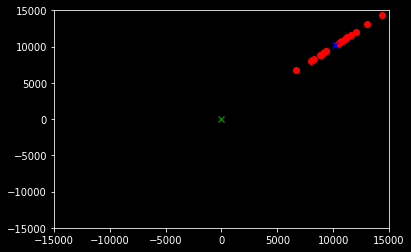

In [17]:
# Prep for BV-graph
plotsize = (-15000,15000)

# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - dt_notscaled.predict(x_val_scaled[select_index[i],:])
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(plotsize[0], plotsize[1])
plt.ylim(plotsize[0], plotsize[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

### Run DT on scaled variables (STD)

In [18]:
dt_scaledstd = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaledstd.fit(x_train_scaledstd, y_train)

DecisionTreeRegressor(random_state=2023)

In [19]:
y_pred_dt_scaledstd = dt_scaledstd.predict(x_val_scaledstd)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaledstd)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaledstd))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaledstd))


RMSE: 8153.841152
R^2: 0.729611
MAPE: 0.104714


Mean Error, x = -184.934476  y = -184.934476
Mean Var Error, x = 17826335.368777  y = 17826335.368777


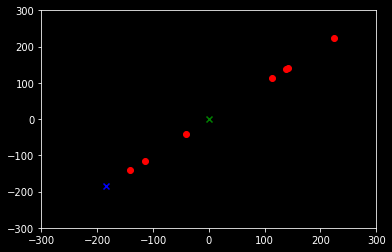

In [20]:
# Prep for BV-graph
plotsize = (-300,300)

# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaledstd[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(plotsize[0], plotsize[1])
plt.ylim(plotsize[0], plotsize[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )


### Run DT on scaled variables (Robust + STD)

In [21]:
dt_scaled = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled.fit(x_train_scaled, y_train)

DecisionTreeRegressor(random_state=2023)

In [22]:
y_pred_dt_scaled = dt_scaled.predict(x_val_scaled)
print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled))


RMSE: 6787.011938
R^2: 0.812664
MAPE: 0.112231


Mean Error, x = -311.033809  y = -311.033809
Mean Var Error, x = 21661116.901761  y = 21661116.901761


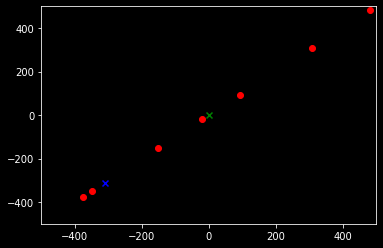

In [23]:
# Prep for BV-graph
plotsize = (-500,500)

# Create Bias-Variance graph for DT1

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(plotsize[0], plotsize[1])
plt.ylim(plotsize[0], plotsize[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled = np.mean(error[:,0])
mean_var_error_dt_scaled =np.mean(var[:,0])

## Run feature importance analysis on DT on scaled variables (RBST + STD)

(0.0, 0.6)

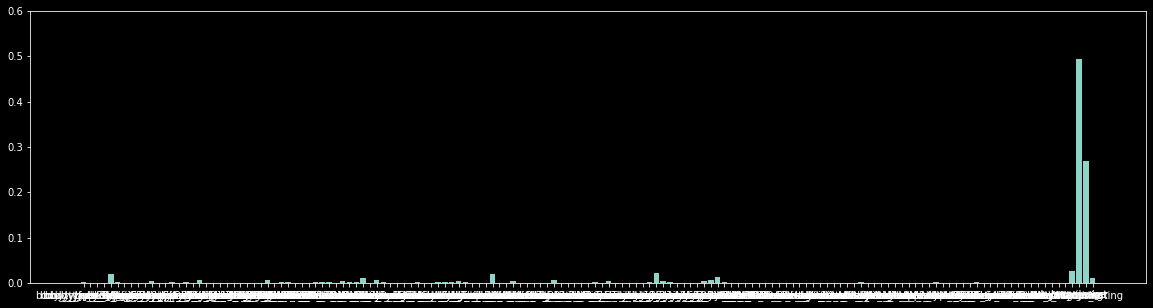

In [24]:
#all features
f = plt.subplots(figsize=(20,5))
plt.bar(col_names[:],list(dt_scaled.feature_importances_[:]))
plt.ylim(0,0.6)

Note: low feature importance noted likely because the one-hot encoding makes for sparse data. Hence zoom in on high feature importance variables.

(0.0, 0.1)

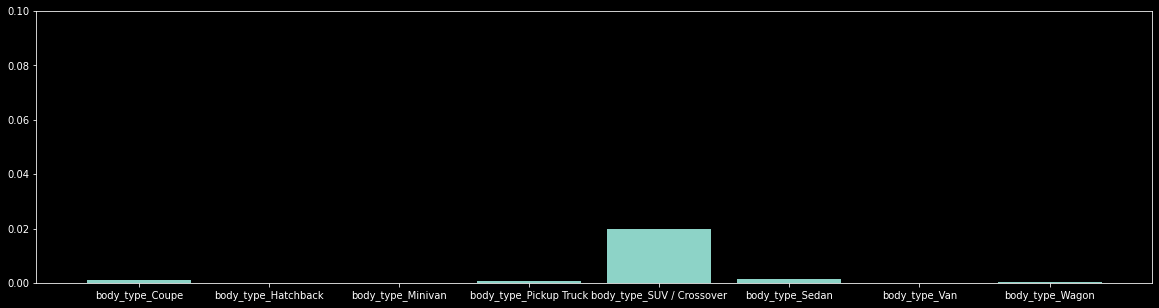

In [25]:
# body type
left, right = 0, 8

f = plt.subplots(figsize=(20,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

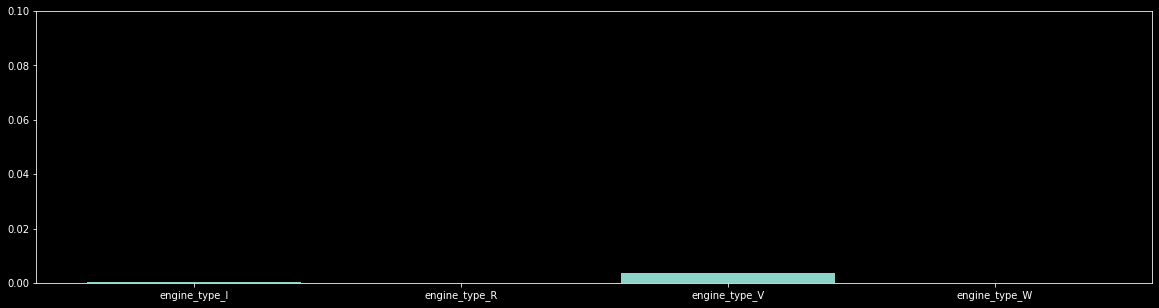

In [26]:
# engine type
left, right = 8, 12

f = plt.subplots(figsize=(20,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

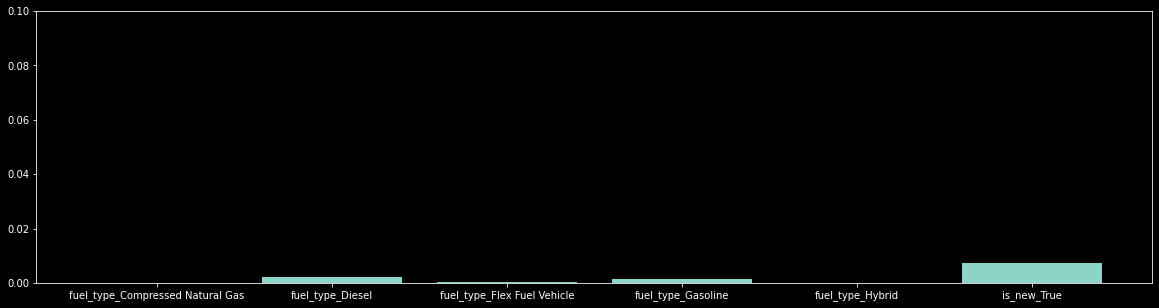

In [27]:
# fuel type & is_new_True
left, right = 12, 18

f = plt.subplots(figsize=(20,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

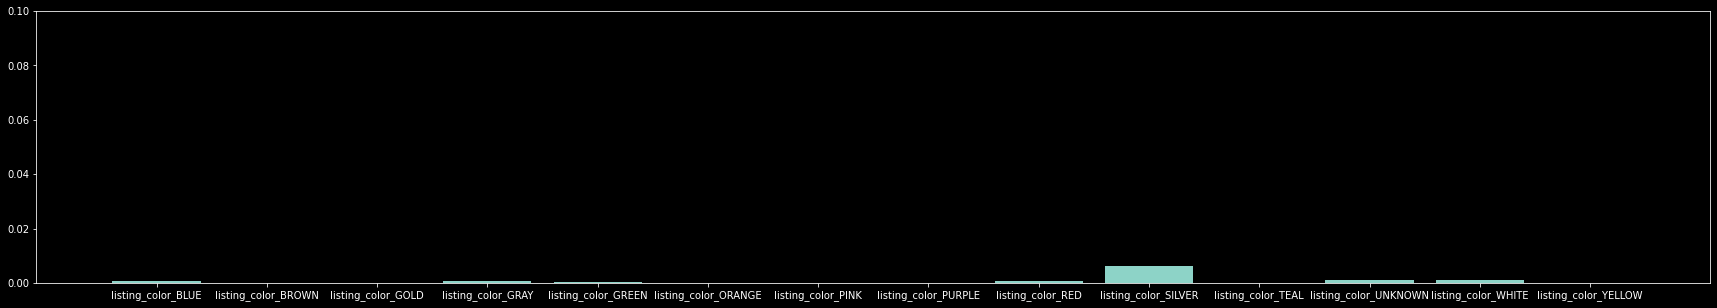

In [28]:
# listing_color
left, right = 18,32

f = plt.subplots(figsize=(30,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

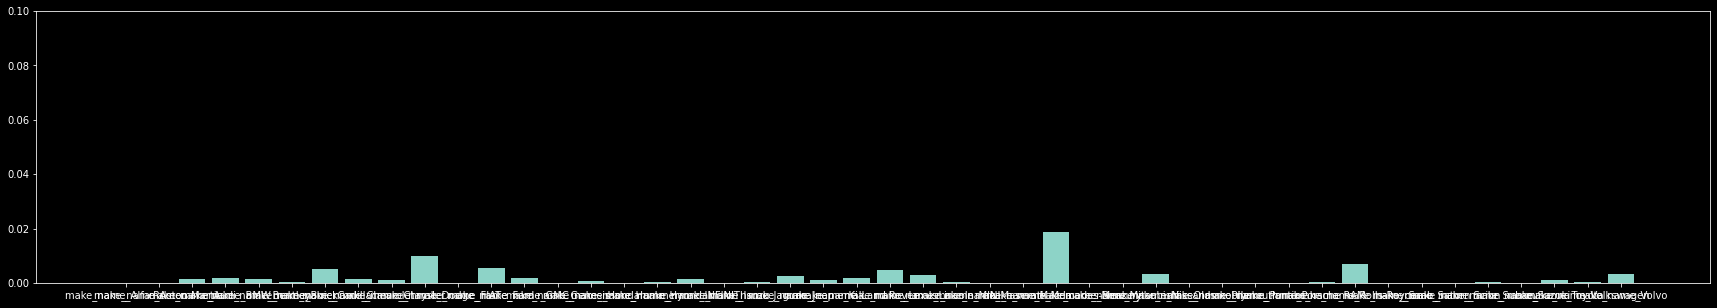

In [29]:
# make_name
left, right = 32,78

f = plt.subplots(figsize=(30,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

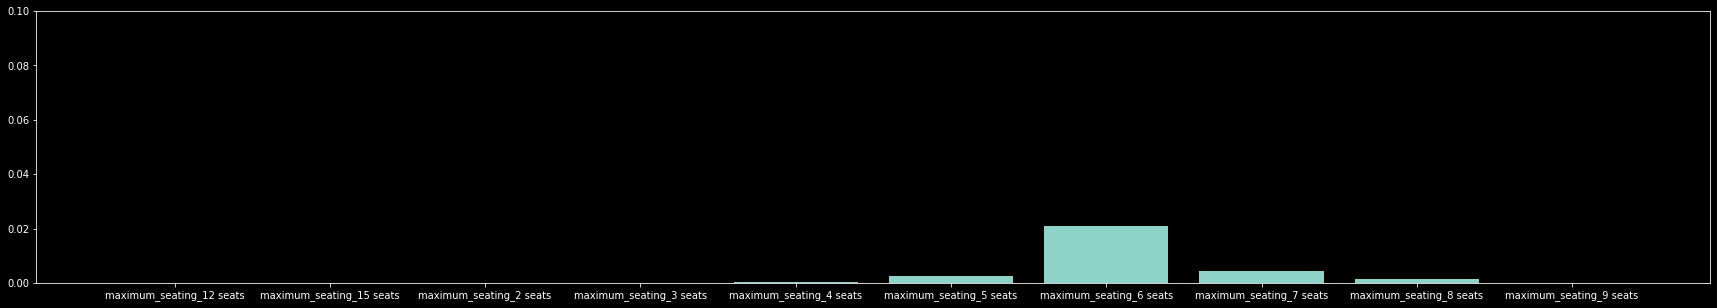

In [30]:
# maximum_seating
left, right = 78,88

f = plt.subplots(figsize=(30,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

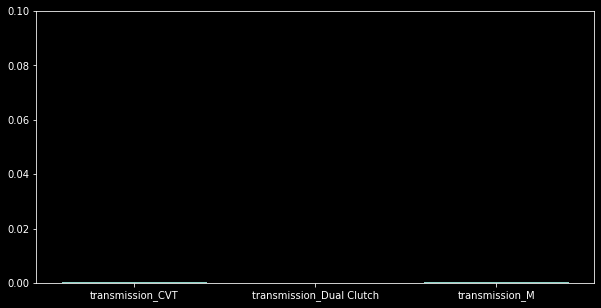

In [31]:
# transmission
left, right = 88,91

f = plt.subplots(figsize=(10,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

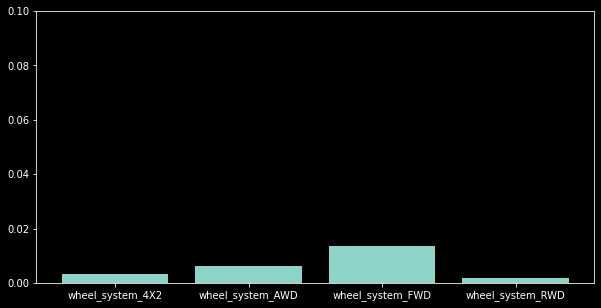

In [32]:
# wheel_system
left, right = 91,95

f = plt.subplots(figsize=(10,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

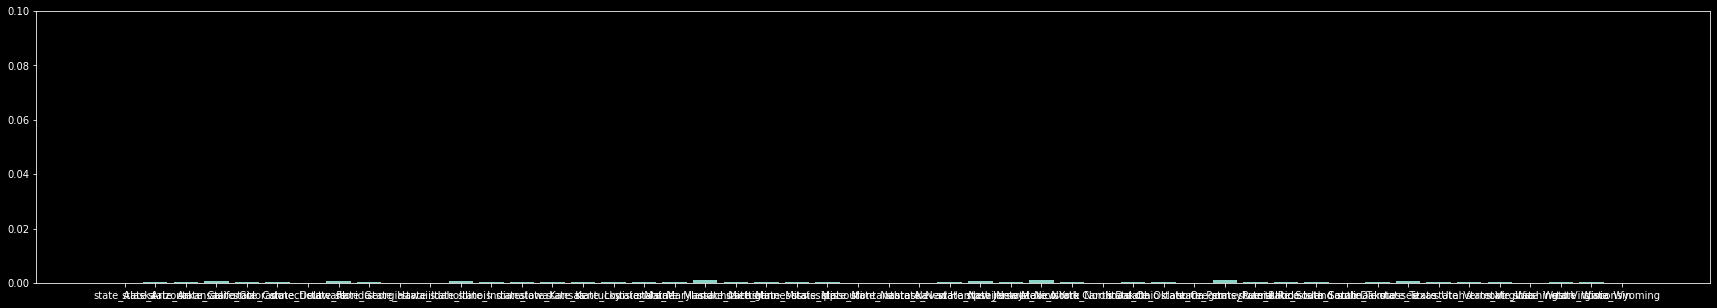

In [33]:
# state
left, right = 95,145

f = plt.subplots(figsize=(30,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.6)

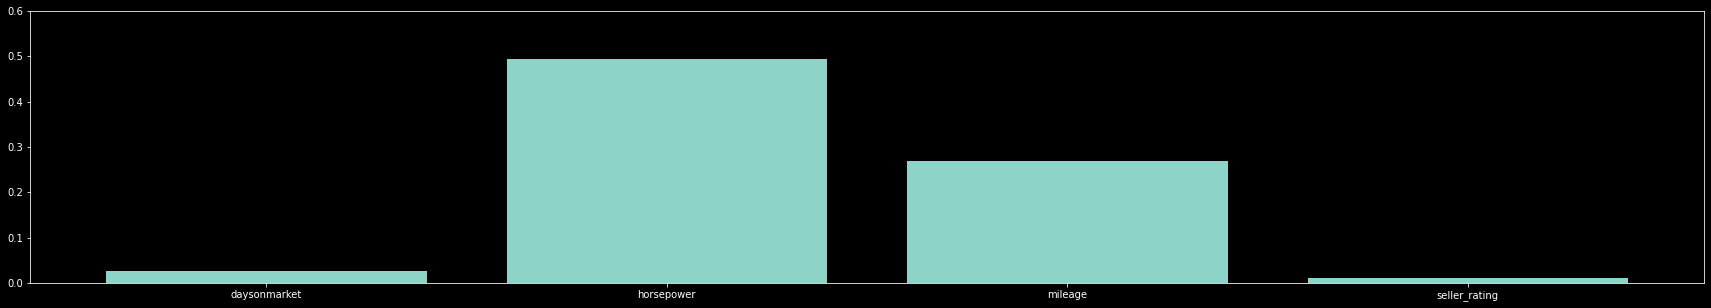

In [34]:
# continuous variables
left = 145

f = plt.subplots(figsize=(30,5))
plt.bar(col_names[left:],list(dt_scaled.feature_importances_[left:]))
plt.ylim(0,0.6)

## Omit variables based on feature importance results

In [35]:
def omit_var(start_idx, end_idx, data):
    idx_list = [idx for idx in range(start_idx,end_idx +1)]
    return np.delete(data, idx_list, axis=1)

In [36]:
standard_plot_size = (-1000,1000)

### Omit tranmission variable

In [37]:
# check col indexes
print(col_names[90], col_names[88])

transmission_M transmission_CVT


In [38]:
# omit columns
col_names2 = copy.deepcopy(col_names)
start_idx, end_idx = 88, 90

x_test_scaled2 = omit_var(start_idx, end_idx, x_test_scaled)
x_train_scaled2 = omit_var(start_idx, end_idx, x_train_scaled)
x_val_scaled2 = omit_var(start_idx, end_idx, x_val_scaled)

del col_names2[start_idx : end_idx+1]

In [39]:
x_val_scaled2.shape

(317342, 146)

##### Run DT Regression

In [40]:
dt_scaled_2 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_2.fit(x_train_scaled2, y_train)

DecisionTreeRegressor(random_state=2023)

In [41]:
y_pred_dt_scaled_2 = dt_scaled_2.predict(x_val_scaled2)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_2)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_2))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_2))


RMSE: 6803.654947
R^2: 0.811744
MAPE: 0.112848


Mean Error, x = -266.134609  y = -266.134609
Mean Var Error, x = 20650338.287766  y = 20650338.287766


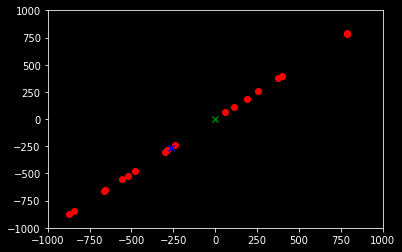

In [42]:
# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_2[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_2 = np.mean(error[:,0])
mean_var_error_dt_scaled_2 =np.mean(var[:,0])

### Omit fuel_type variable

In [43]:
# check col indexes
print(col_names2[12],"/" , col_names2[16])

fuel_type_Compressed Natural Gas / fuel_type_Hybrid


In [44]:
# omit columns
col_names3 = copy.deepcopy(col_names2)
start_idx, end_idx = 12, 16

x_test_scaled3 = omit_var(start_idx, end_idx, x_test_scaled2)
x_train_scaled3 = omit_var(start_idx, end_idx, x_train_scaled2)
x_val_scaled3 = omit_var(start_idx, end_idx, x_val_scaled2)

del col_names3[start_idx : end_idx+1]

In [45]:
x_val_scaled3.shape

(317342, 141)

##### Run DT Regression

In [46]:
dt_scaled_3 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_3.fit(x_train_scaled3, y_train)

DecisionTreeRegressor(random_state=2023)

In [47]:
y_pred_dt_scaled_3 = dt_scaled_3.predict(x_val_scaled3)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_3)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_3))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_3))


RMSE: 6820.474784
R^2: 0.810812
MAPE: 0.113254


Mean Error, x = -154.551042  y = -154.551042
Mean Var Error, x = 19750958.856510  y = 19750958.856510


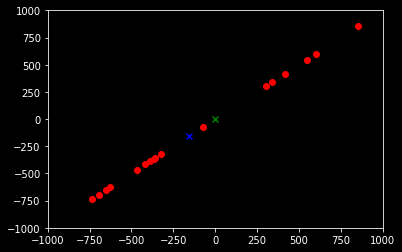

In [48]:
# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_3[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_3 = np.mean(error[:,0])
mean_var_error_dt_scaled_3 =np.mean(var[:,0])

### Omit (some) maximum_seating variable

In [49]:
# check col indexes
print(col_names3[73] , "/", col_names3[76])
print(col_names3[82])

maximum_seating_12 seats / maximum_seating_3 seats
maximum_seating_9 seats


In [50]:
# omit columns
col_names4 = copy.deepcopy(col_names3)
start_idx, end_idx = 73,76

x_test_scaled4 = omit_var(start_idx, end_idx, x_test_scaled3)
x_train_scaled4 = omit_var(start_idx, end_idx, x_train_scaled3)
x_val_scaled4 = omit_var(start_idx, end_idx, x_val_scaled3)

del col_names4[start_idx : end_idx+1]

In [51]:
# omit columns
start_idx, end_idx = 82,82

x_test_scaled4 = omit_var(start_idx, end_idx, x_test_scaled4)
x_train_scaled4 = omit_var(start_idx, end_idx, x_train_scaled4)
x_val_scaled4 = omit_var(start_idx, end_idx, x_val_scaled4)

del col_names4[start_idx]

In [52]:
x_val_scaled4.shape

(317342, 136)

##### Run DT Regression

In [53]:
dt_scaled_4 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_4.fit(x_train_scaled4, y_train)

DecisionTreeRegressor(random_state=2023)

In [54]:
y_pred_dt_scaled_4 = dt_scaled_4.predict(x_val_scaled4)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_4)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_4))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_4))

RMSE: 6804.254879
R^2: 0.811711
MAPE: 0.113347


Mean Error, x = -210.877209  y = -210.877209
Mean Var Error, x = 22038417.658904  y = 22038417.658904


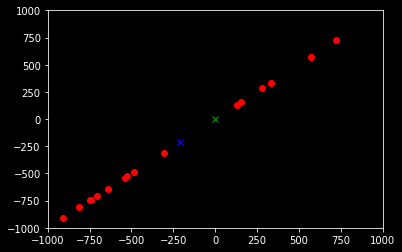

In [55]:
# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_4[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_4 = np.mean(error[:,0])
mean_var_error_dt_scaled_4 =np.mean(var[:,0])

### Omit engine_type variable

In [56]:
# check col indexes
print(col_names4[8], "/", col_names4[11])


engine_type_I / engine_type_W


In [57]:
# omit columns
col_names5 = copy.deepcopy(col_names4)
start_idx, end_idx = 8, 11

x_test_scaled5 = omit_var(start_idx, end_idx, x_test_scaled4)
x_train_scaled5 = omit_var(start_idx, end_idx, x_train_scaled4)
x_val_scaled5 = omit_var(start_idx, end_idx, x_val_scaled4)

del col_names5[start_idx : end_idx+1]

In [58]:
x_val_scaled5.shape

(317342, 132)

##### Run DT Regression

In [59]:
dt_scaled_5 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_5.fit(x_train_scaled5, y_train)

DecisionTreeRegressor(random_state=2023)

In [60]:
y_pred_dt_scaled_5 = dt_scaled_5.predict(x_val_scaled5)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_5)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_5))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_5))

RMSE: 6812.726385
R^2: 0.811242
MAPE: 0.113493


Mean Error, x = -168.517042  y = -168.517042
Mean Var Error, x = 18502462.139881  y = 18502462.139881


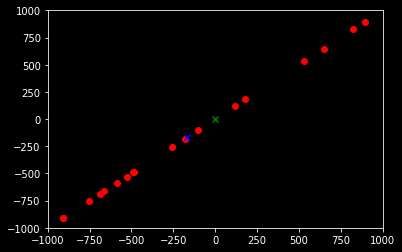

In [61]:
# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_5[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_5 = np.mean(error[:,0])
mean_var_error_dt_scaled_5 =np.mean(var[:,0])

### Omit body_type variable

In [69]:
# check col indexes
print(col_names5[0] , "/", col_names5[7])

body_type_Coupe / body_type_Wagon


In [71]:
# omit columns
col_names6 = copy.deepcopy(col_names5)
start_idx, end_idx = 0,7
x_test_scaled6 = omit_var(start_idx, end_idx, x_test_scaled5)
x_train_scaled6 = omit_var(start_idx, end_idx, x_train_scaled5)
x_val_scaled6 = omit_var(start_idx, end_idx, x_val_scaled5)

del col_names6[start_idx : end_idx+1]

In [72]:
x_train_scaled6.shape

(952025, 124)

##### Run DT Regression

In [73]:
dt_scaled_6 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_6.fit(x_train_scaled6, y_train)

DecisionTreeRegressor(random_state=2023)

In [74]:
y_pred_dt_scaled_6 = dt_scaled_6.predict(x_val_scaled6)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_6)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_6))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_6))

RMSE: 5719.360552
R^2: 0.866967
MAPE: 0.116472


Mean Error, x = -200.987876  y = -200.987876
Mean Var Error, x = 18927930.984058  y = 18927930.984058


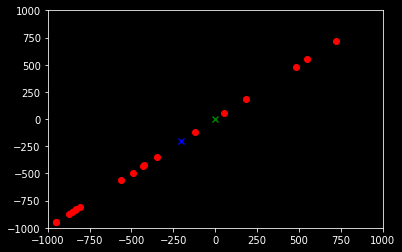

In [75]:
# Create Bias-Variance graph 

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_6[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_6 = np.mean(error[:,0])
mean_var_error_dt_scaled_6 =np.mean(var[:,0])

### Omit listing_colour variable

In [89]:
# check col indexes
print(col_names6[1] , "/", col_names6[14])

listing_color_BLUE / listing_color_YELLOW


In [90]:
# omit columns
col_names7 = copy.deepcopy(col_names6)
start_idx, end_idx = 1,14
x_test_scaled7 = omit_var(start_idx, end_idx, x_test_scaled6)
x_train_scaled7 = omit_var(start_idx, end_idx, x_train_scaled6)
x_val_scaled7 = omit_var(start_idx, end_idx, x_val_scaled6)

del col_names7[start_idx : end_idx+1]

In [91]:
x_train_scaled7.shape

(952025, 110)

##### Run DT Regression

In [92]:
dt_scaled_7 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_7.fit(x_train_scaled7, y_train)

DecisionTreeRegressor(random_state=2023)

In [93]:
y_pred_dt_scaled_7 = dt_scaled_7.predict(x_val_scaled7)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_7)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_7))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_7))

RMSE: 5712.435964
R^2: 0.867289
MAPE: 0.115389


Mean Error, x = -224.555696  y = -224.555696
Mean Var Error, x = 20180774.655224  y = 20180774.655224


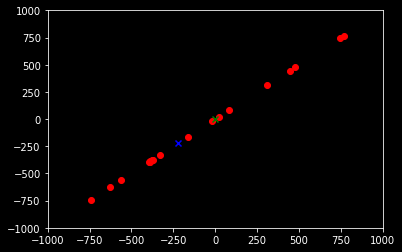

In [94]:
# Create Bias-Variance graph 

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_7[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_7 = np.mean(error[:,0])
mean_var_error_dt_scaled_7 =np.mean(var[:,0])

### Omit state variable

In [111]:
# check col indexes
print(col_names7[56] , "/", col_names7[105])

state_Alaska / state_Wyoming


In [112]:
# omit columns
col_names8 = copy.deepcopy(col_names7)
start_idx, end_idx = 56,105
x_test_scaled8 = omit_var(start_idx, end_idx, x_test_scaled7)
x_train_scaled8 = omit_var(start_idx, end_idx, x_train_scaled7)
x_val_scaled8 = omit_var(start_idx, end_idx, x_val_scaled7)

del col_names8[start_idx : end_idx+1]

In [113]:
x_val_scaled7.shape

(317342, 110)

##### Run DT Regression

In [114]:
dt_scaled_8 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_8.fit(x_train_scaled8, y_train)

DecisionTreeRegressor(random_state=2023)

In [115]:
y_pred_dt_scaled_8 = dt_scaled_8.predict(x_val_scaled8)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_8)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_8))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_8))

RMSE: 5912.048515
R^2: 0.857852
MAPE: 0.122597


Mean Error, x = -353.458163  y = -353.458163
Mean Var Error, x = 24890511.806945  y = 24890511.806945


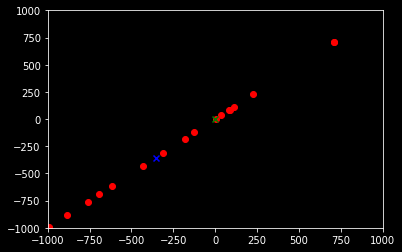

In [116]:
# Create Bias-Variance graph 

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_8[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_8 = np.mean(error[:,0])
mean_var_error_dt_scaled_8 =np.mean(var[:,0])

NOTE: Removal of state leads to increase in MAPE although RMSE drops.

## Plot RMSE, MPSE, R^2, Mean Error & Mean Var Error (from Bias-Variance graphs) changes as variables are dropped

In [117]:
models = ['dt_scaled','dt_scaled_2','dt_scaled_3','dt_scaled_4', 'dt_scaled_5', 'dt_scaled_6', 'dt_scaled_7','dt_scaled_8']

RMSE = [np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled)), np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_2)), np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_3)),
        np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_4)), np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_5)), np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_6)), 
        np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_7)),np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_8))]

R2 = [metrics.r2_score(y_val, y_pred_dt_scaled), metrics.r2_score(y_val, y_pred_dt_scaled_2), metrics.r2_score(y_val, y_pred_dt_scaled_3), metrics.r2_score(y_val, y_pred_dt_scaled_4),
      metrics.r2_score(y_val, y_pred_dt_scaled_5), metrics.r2_score(y_val, y_pred_dt_scaled_6),  metrics.r2_score(y_val, y_pred_dt_scaled_7), metrics.r2_score(y_val, y_pred_dt_scaled_8)]

MAPE = [mape(y_val, y_pred_dt_scaled), mape(y_val, y_pred_dt_scaled_2), mape(y_val, y_pred_dt_scaled_3), mape(y_val, y_pred_dt_scaled_4), mape(y_val, y_pred_dt_scaled_5),
        mape(y_val, y_pred_dt_scaled_6),mape(y_val, y_pred_dt_scaled_7),mape(y_val, y_pred_dt_scaled_8)]

mean_error_BV = [abs(mean_error_dt_scaled), abs(mean_error_dt_scaled_2), abs(mean_error_dt_scaled_3), abs(mean_error_dt_scaled_4), abs(mean_error_dt_scaled_5),
                 abs(mean_error_dt_scaled_6),abs(mean_error_dt_scaled_7),abs(mean_error_dt_scaled_8)]

mean_var_error_BV = [mean_var_error_dt_scaled, mean_var_error_dt_scaled_2, mean_var_error_dt_scaled_3, mean_var_error_dt_scaled_4, mean_var_error_dt_scaled_5, mean_var_error_dt_scaled_6,
                     mean_var_error_dt_scaled_7,mean_var_error_dt_scaled_8]


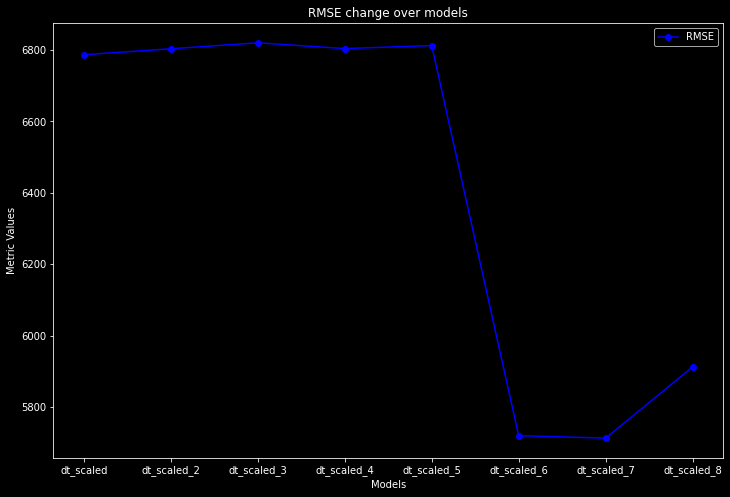

In [118]:
plt.figure(figsize = (12, 8))
plt.plot(models, RMSE, 'bo-', label = 'RMSE')
plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('RMSE change over models')
plt.legend()
plt.show()

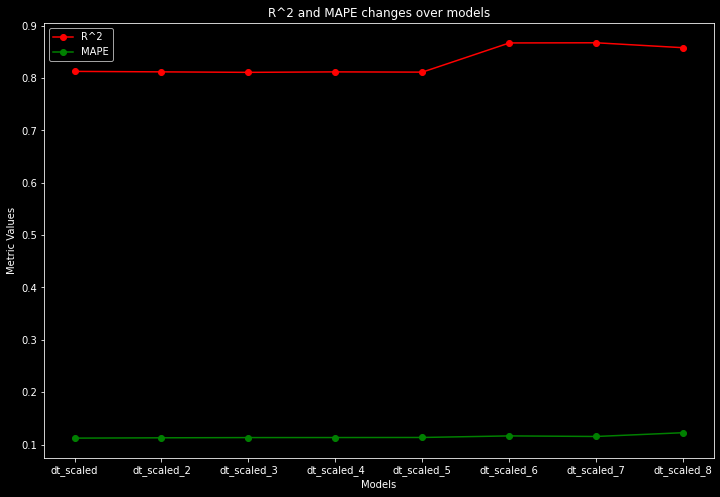

In [119]:
plt.figure(figsize = (12, 8))
plt.plot(models, R2, 'ro-', label = 'R^2')
plt.plot(models, MAPE, 'go-', label = 'MAPE')
plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('R^2 and MAPE changes over models')
plt.legend()
plt.show()

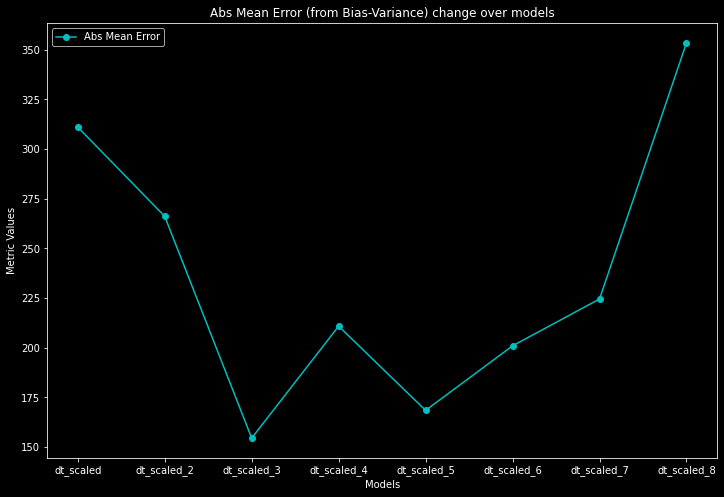

In [121]:
plt.figure(figsize = (12, 8))
plt.plot(models, mean_error_BV, 'co-', label = 'Abs Mean Error')
plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('Abs Mean Error (from Bias-Variance) change over models')
plt.legend()
plt.show()

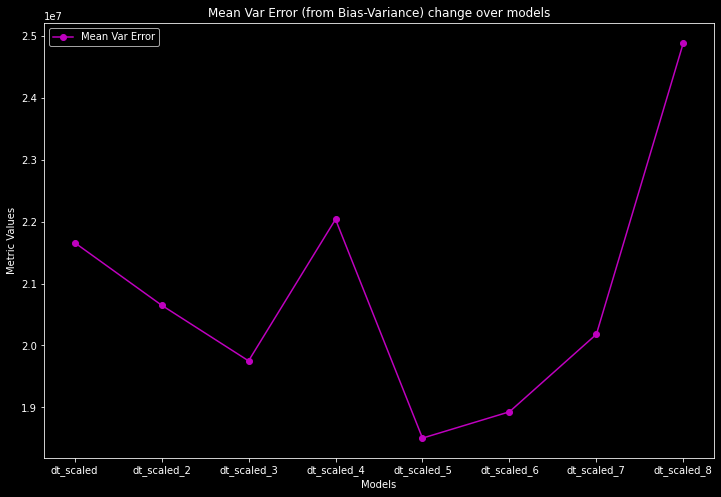

In [122]:
plt.figure(figsize = (12, 8))
plt.plot(models, mean_var_error_BV, 'mo-', label = 'Mean Var Error')
plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('Mean Var Error (from Bias-Variance) change over models')
plt.legend()
plt.show()

## Run dt_scaled_7 on Test data

In [124]:
y_pred_dt_scaled_7_TEST = dt_scaled_7.predict(x_test_scaled7)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt_scaled_7_TEST)))
print("R^2: %.6f" % metrics.r2_score(y_test, y_pred_dt_scaled_7_TEST))
print("MAPE: %.6f" % mape(y_test, y_pred_dt_scaled_7_TEST))

RMSE: 7071.207627
R^2: 0.790531
MAPE: 0.120827


Mean Error, x = -97.176869  y = -97.176869
Mean Var Error, x = 23708908.759777  y = 23708908.759777


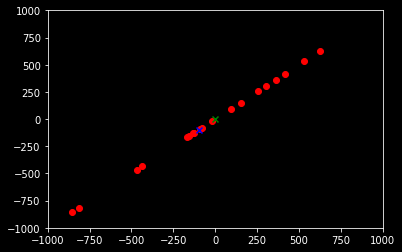

In [126]:
# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_test[select_index[i]] - y_pred_dt_scaled_7_TEST[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaledstd_7_TEST = np.mean(error[:,0])
mean_var_error_dt_scaledstd_7_TEST =np.mean(var[:,0])

In [144]:
print(col_names7)

['is_new_True', 'make_name_Alfa Romeo', 'make_name_Aston Martin', 'make_name_Audi', 'make_name_BMW', 'make_name_Bentley', 'make_name_Buick', 'make_name_Cadillac', 'make_name_Chevrolet', 'make_name_Chrysler', 'make_name_Dodge', 'make_name_FIAT', 'make_name_Ford', 'make_name_GMC', 'make_name_Genesis', 'make_name_Honda', 'make_name_Hummer', 'make_name_Hyundai', 'make_name_INFINITI', 'make_name_Isuzu', 'make_name_Jaguar', 'make_name_Jeep', 'make_name_Kia', 'make_name_Land Rover', 'make_name_Lexus', 'make_name_Lincoln', 'make_name_MINI', 'make_name_Maserati', 'make_name_Mazda', 'make_name_Mercedes-Benz', 'make_name_Mercury', 'make_name_Mitsubishi', 'make_name_Nissan', 'make_name_Oldsmobile', 'make_name_Plymouth', 'make_name_Pontiac', 'make_name_Porsche', 'make_name_RAM', 'make_name_Rolls-Royce', 'make_name_Saab', 'make_name_Saturn', 'make_name_Scion', 'make_name_Subaru', 'make_name_Suzuki', 'make_name_Toyota', 'make_name_Volkswagen', 'make_name_Volvo', 'maximum_seating_4 seats', 'maximum_se

In [129]:
print("Final Variables: ")
print("is_new_True,make_name (encoded), maximum_seating (4,5,6,7,8,9) (encoded), wheel_system (encooded),")
print("state (encoded), daysonmarket, horsepower, mileage, seller_rating")


Final Variables: 
is_new_True,make_name (encoded), maximum_seating (4,5,6,7,8,9) (encoded), wheel_system (encooded),
state (encoded), daysonmarket, horsepower, mileage, seller_rating


### Run K-Fold

In [134]:
# Copy model so code uses 1 object only 
kf_model = copy.deepcopy(dt_scaled_7)

#Prep data
kf  = KFold(n_splits = 10, shuffle = True, random_state = random_state)

x_kf = copy.deepcopy(x)

start_idx, end_idx = 88, 90
x_kf = omit_var(start_idx, end_idx, x_kf)

start_idx, end_idx = 12, 16
x_kf = omit_var(start_idx, end_idx, x_kf)

start_idx, end_idx = 73,76
x_kf = omit_var(start_idx, end_idx, x_kf)

start_idx, end_idx = 82, 82
x_kf = omit_var(start_idx, end_idx, x_kf)

start_idx, end_idx = 8, 11
x_kf = omit_var(start_idx, end_idx, x_kf)

In [135]:
#Run k-fold
print('RUN K-FOLD, splits = 10, shuffle = True')

final_scores_cross_val_R2 = cross_val_score(kf_model, x_kf, y, scoring='r2', cv=kf, n_jobs=1)


RUN K-FOLD, splits = 10, shuffle = True


In [136]:
print('R^2:')
for i in final_scores_cross_val_R2:
    print('%5f' % i)

R^2:
0.886880
0.910560
0.724774
0.889525
0.913433
0.809844
0.860962
0.908217
0.786710
0.767847


In [137]:
def mape_kfold(estimator, x, y):
    predicted = estimator.predict(x)
    return sum(abs((y - predicted) / y)) / len(y)

In [138]:
#Run k-fold
print('RUN K-FOLD, splits = 10, shuffle = True')

final_scores_cross_val_MAPE = cross_val_score(kf_model, x_kf, y, scoring=mape_kfold, cv=kf, n_jobs=1)


RUN K-FOLD, splits = 10, shuffle = True


In [139]:
print('MAPE:')
for i in final_scores_cross_val_MAPE:
    print('%5f' % i)

MAPE:
0.099741
0.099181
0.100115
0.098977
0.099957
0.099141
0.099992
0.099790
0.099964
0.099968


# Run MLR to valdiate features omitted

In [140]:
import statsmodels.api as sm
def get_stats(x,y):
    results = sm.OLS(y, x).fit()
    print(results.summary())

In [141]:
print('Run MLR on data with all columns')
print('\r')
get_stats(x_train_scaled,y_train)

Run MLR on data with all columns

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.159
Model:                            OLS   Adj. R-squared (uncentered):              0.158
Method:                 Least Squares   F-statistic:                              1212.
Date:                Sun, 19 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:51:26   Log-Likelihood:                     -1.1226e+07
No. Observations:              952025   AIC:                                  2.245e+07
Df Residuals:                  951877   BIC:                                  2.245e+07
Df Model:                         148                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

In [143]:
print('Run MLR on data with columns in dt_scaled_7')
print('\r')
get_stats(x_train_scaled7,y_train)

Run MLR on data with columns in dt_scaled_7

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.154
Model:                            OLS   Adj. R-squared (uncentered):              0.154
Method:                 Least Squares   F-statistic:                              1595.
Date:                Sun, 19 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:52:31   Log-Likelihood:                     -1.1228e+07
No. Observations:              952025   AIC:                                  2.246e+07
Df Residuals:                  951916   BIC:                                  2.246e+07
Df Model:                         109                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.9

# Run Gradient Boosted Regression model

In [59]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


In [86]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mape',
    'learning_rate': 0.3,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 300
}

pipe = make_pipeline(
    XGBRegressor(tree_method='gpu_hist', **params)
)

param_grid = {
    'xgbregressor__n_estimators': [200, 300, 400, 500],
    'xgbregressor__learning_rate': [0.1, 0.2, 0.25, 0.3]
}
cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='neg_mean_absolute_percentage_error')

In [87]:
grid.fit(x_train_scaled5, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=2023, shuffle=True),
             estimator=Pipeline(steps=[('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=0.8,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric='mape',
                                                     feature_types=None,
                                                     gamma=0, gpu_id=None,
                                                     grow_po

In [88]:
best_estimator = grid.best_estimator_
print("Best hyperparameters: ", grid.best_params_)

Best hyperparameters:  {'xgbregressor__learning_rate': 0.3, 'xgbregressor__n_estimators': 500}


In [93]:
print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_train, best_estimator.predict(x_train_scaled5))))
print("R^2: %.6f" % metrics.r2_score(y_train, best_estimator.predict(x_train_scaled5)))
print("MAPE: %.6f" % mape(y_train, best_estimator.predict(x_train_scaled5)))

RMSE: 3674.379614
R^2: 0.946114
MAPE: 0.088713


In [90]:
y_pred_XGBoost_scaled = best_estimator.predict(x_test_scaled5)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_XGBoost_scaled)))
print("R^2: %.6f" % metrics.r2_score(y_test, y_pred_XGBoost_scaled))
print("MAPE: %.6f" % mape(y_test, y_pred_XGBoost_scaled))

RMSE: 7983.763431
R^2: 0.732978
MAPE: 0.155476


Note: overfitting identified

In [135]:
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'max_depth': 6,
    'n_estimators': 150
}

xgDT = XGBRegressor(tree_method='gpu_hist', **params)
xgDT.fit(x_train_scaled5, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [136]:
y_pred_xgDT_scaled = xgDT.predict(x_test_scaled5)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgDT_scaled)))
print("R^2: %.6f" % metrics.r2_score(y_test, y_pred_xgDT_scaled))
print("MAPE: %.6f" % mape(y_test, y_pred_xgDT_scaled))

RMSE: 6921.511713
R^2: 0.799306
MAPE: 0.164349
